<a href="https://colab.research.google.com/github/woonghee97/deep_learning/blob/DeepLearning/MiniProject_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniProject#1
안녕하세요, 딥러닝 조교 한창완입니다. 본 자료는 딥러닝 실습 수업을 위해 제작된 것입니다.

파이썬 문법
- 점프투파이썬(https://wikidocs.net/book/1 ) 참고

이번 과제는 Convolutional Neural Network를 이용하여 Classification을 해보는 것입니다.


##  Pet 분류기
만들어볼 모델은 개와 고양이의 종을 분류하는 모델입니다.
반려동물에는 많은 종이 있지만 그중에서 25가지종을 분류해보겠습니다.

keras에서 이미지의 train set을 생성하는 방법은 ImageDataGenerator모듈의 flow_from_directory를 사용하여 불러오는 방법이 있습니다. 저희의 실습환경은 구글 Colab이기 때문에, 위의 방법은 효율적이지 못합니다.


※flow_from_directory은 사진을 한장씩 읽어서, 데이터셋을 만드는데 구글 colab은 이러한 방식이 매우 오래걸립니다. 또한 Google 드라이브에 올리는 것 역시 오래 걸립니다.

그래서 numpy형태로 저장해둔  train set을 사용하여 실습 및 미니프로젝트를 진행하겠습니다. 

##1.먼저 구글드라이브와 colab을 연동해봅시다.
- step 1: 구글드라이브의 '**내 드라이브**' 아래에 '**Pet**' 이라는 이름의 폴더를 만들어보세요.
- step 2: 이 프로젝트를 해당 경로에 놓고, 올려드린 **imageData_25.npy, imageDataLabel.npy**를 업로드 해서 넣어주세요.(약 2분정도 소요됩니다.)
- step 3: 다 되었다면 아래처럼 폴더에 파일이 있을겁니다.

내 드라이브

L Pet
> L MiniProject#1.ipynb

> L imageData_25.npy

> L imageDataLabel_25.npy


- step 4: 이제 구글드라이브와 colab을 연동하겠습니다. 아래의 코드를 실행해주세요. 링크하나와 authorization code 또는 새로운 창이 나올겁니다.
[참고링크](https://somjang.tistory.com/entry/Google-Colab%EC%97%90%EC%84%9C-Google-Drive%EC%99%80-%EC%97%B0%EB%8F%99%ED%95%98%EA%B8%B0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
if os.getcwd() != '/content/drive/My Drive':
    os.chdir('./drive/My Drive')

Mounted at /content/drive/


    Mounted at /content/drive/ 
라는 문구가 나왔다면 성공입니다.아래의 명령어를 실행하여

    /content/drive/My Drive
이 나왔는지 확인해주세요

In [ ]:
!pwd

/content/drive/My Drive


## 2.train set으로 이미지와 이름확인하기

일단 train set을 모두 가져옵니다.

In [ ]:
import numpy as np
import tensorflow as tf

train_images = np.load("./Pet/imageData_25.npy", allow_pickle=True)
train_labels = np.load("./Pet/imageDataLabel_25.npy", allow_pickle=True)

이제 가져온 train set을 확인해봅시다. 

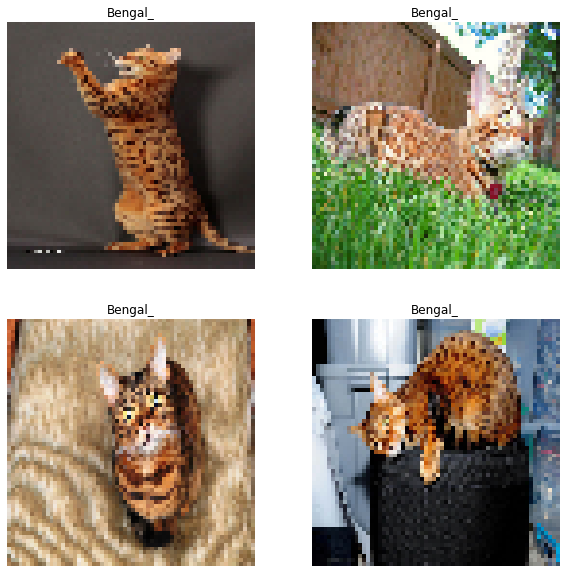

In [ ]:
import matplotlib.pyplot as plt

def draw_Pet(train_images, train_labels,image_offset =1000):
  data_size = train_images.shape[0]
  if image_offset>= data_size-4:
    image_offset =data_size-4
  fig = plt.figure()
  fig.set_size_inches(10, 10, forward=True)
  rows=2
  cols=2
  
  for i in range(4):
    ax = fig.add_subplot(rows,cols,i+1)
    ax.imshow(train_images[image_offset+i])
    ax.set_title(train_labels[image_offset+i])
    ax.axis("off")

draw_Pet(train_images, train_labels,image_offset =400)

## 3.데이터셋 전처리

사진과 이름이 잘맞나요? 이제 데이터셋에 대한 전처리를 하겠습니다.
이미지의 픽셀밝기를 0에서 1사이로 정규화(Normalize)하겠습니다.

In [ ]:
train_size = train_images.shape[0]
print("train data size is ", train_size)

train_images =train_images.reshape(train_size, 64, 64,3)
print(train_images.shape)
train_images = train_images / 255.0

train data size is  2500
(2500, 64, 64, 3)


이번에는 머신러닝을 위한 라이브러리인 사이킷런을 사용하여, 데이터셋의 라벨(캐릭터 이름)에 One-hot encoding을 해보겠습니다. 

출력결과를 보시면 알겟지만, One-hot encoding의 결과로 20 종류의 이름은 크기가 20인 벡터로 매핑됩니다.
자세한 설명은 [이 글](https://wikidocs.net/22647)을 참조해주세요.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc= OneHotEncoder()
train_labels_new = train_labels.reshape(-1,1)
enc.fit(train_labels_new)

#changed the names through one-hot encoding.
train_labels_onehot = np.array(enc.transform(train_labels_new).toarray())

print("one-hot encoding train shape is ",train_labels_onehot.shape)
print(train_labels_onehot)

one-hot encoding train shape is  (2500, 25)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


## 4.CNN기반의 반려동물 종 분류모델 생성 및 학습

CNN사용간에 Colab의 GPU를 활용하여 봅시다. 현재 프로젝트 상단 헤더의 메뉴바에서 **수정 - 노트 설정**으로 들어가서  **하드웨어 가속기**를 **None**에서 **GPU**로 바꿔주세요. 

이제 모델의 생성이나 학습의 코드전에 
`with tf.device('/gpu:0'):` 라는 코드한줄을 추가하여, colab의 GPU를 활용하게 해봅시다.

주의할 점은 너무 오랜시간동안 GPU를 사용해버리면, 구글 colab에서 GPU사용을 막아버리니 주의하세요.

이제 오늘의 주 내용인 CNN layer를 활용한 모델을 만들어봅시다.

- CNN layer를 통해서 이미지의 feature map을 얻습니다. 
- Max pooling을 통하여 이미지의 사이즈를 줄입니다.
- Flatten layer를 통하여 이미지의 feature map을 벡터형태로 바꿉니다.
- Dense layer와 마지막 softmax activation fuction을 통해서 이미지를 분류합니다.

In [ ]:
from keras import layers
from keras import models
import tensorflow as tf

with tf.device('/gpu:0'):
  characters = 25
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='relu')) 
  model.add(layers.Conv2D(512, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(characters, activation='softmax'))

  model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                    

이제 만들어진 모델에 학습을 시켜봅시다.



In [ ]:
with tf.device('/gpu:0'):
  model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy'],
                )
  batch_size =8 

  history=model.fit(train_images, train_labels_onehot, batch_size=batch_size, epochs=50, verbose=1)

Epoch 1/50
313/313 [==============================] - 17s 23ms/step - loss: 3.2198 - accuracy: 0.0428
Epoch 2/50
313/313 [==============================] - 7s 22ms/step - loss: 3.2144 - accuracy: 0.0392
Epoch 3/50
313/313 [==============================] - 7s 22ms/step - loss: 3.1993 - accuracy: 0.0528
Epoch 4/50
313/313 [==============================] - 7s 22ms/step - loss: 3.1503 - accuracy: 0.0824
Epoch 5/50
313/313 [==============================] - 7s 23ms/step - loss: 3.0894 - accuracy: 0.1012
Epoch 6/50
313/313 [==============================] - 7s 23ms/step - loss: 3.0337 - accuracy: 0.1044
Epoch 7/50
313/313 [==============================] - 7s 22ms/step - loss: 2.9875 - accuracy: 0.1208
Epoch 8/50
313/313 [==============================] - 7s 22ms/step - loss: 2.9375 - accuracy: 0.1368
Epoch 9/50
313/313 [==============================] - 7s 22ms/step - loss: 2.8939 - accuracy: 0.1492
Epoch 10/50
313/313 [==============================] - 7s 22ms/step - loss: 2.8335 - accur

결과를 실제로 이미지와 이름 쌍으로 확인해볼까요? 먼저 모델의 추론 결과들을 모델의 predict함수로 모두 받습니다.
사이킷런을 통해서 one-hot encoding된 결과는 inverse_transform함수를 통해서 되돌릴 수 있습니다.

In [ ]:
with tf.device('/gpu:0'):
    predictions = model.predict(train_images)
    decoded_predictions_train = enc.inverse_transform(predictions)

아래의 코드는 이미지와 예측된 라벨이 잘맞았는지 확인하는 코드입니다. 인덱스(index)를 바꿔가며 테스트해보세요.  

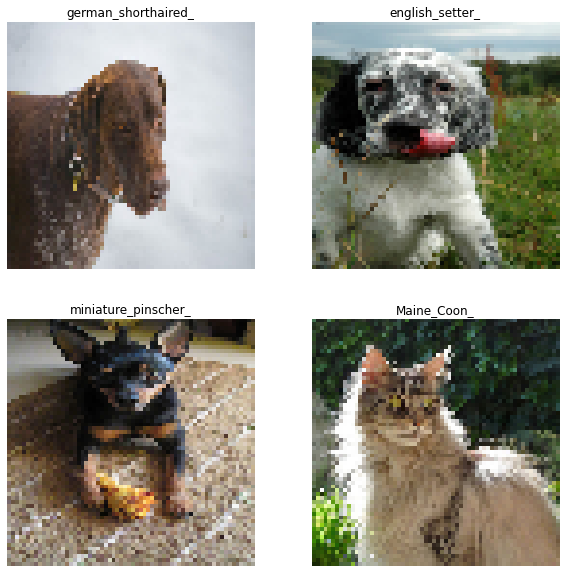

In [ ]:
import random

def view_test(decoded_predictions,images):

  fig = plt.figure()
  fig.set_size_inches(10, 10, forward=True)
  rows=2
  cols=2
  index = [x for x in range(0, 2500)]
  index = random.sample(index, 4)

  for i in range(4):
    ax = fig.add_subplot(rows,cols,i+1)
    ax.imshow((images[index[i]]*255).astype('uint8'))
    ax.set_title(decoded_predictions[index[i]][0])
    ax.axis("off")


view_test(decoded_predictions_train,train_images)

## 5.완성된 모델의 저장과 재사용

완성된 모델은 모델의 구조와 가중치를 포함하여 한번에 저장할 수 있습니다. 아래의 코드를 실행하여 모델을 저장해보세요.

In [ ]:
import tensorflow as tf

#saved_model이라는 이름으로 해당 모델을 저장한다.
model.save("./Pet/saved_model")

INFO:tensorflow:Assets written to: ./Pet/saved_model/assets


구글드라이브를 살펴보시면 다음과 같이 **saved_model**이라는 폴더가 생길겁니다. 해당 폴더에는 모델의 구조와 가중치등이 저장되어있습니다.

내 드라이브

L Pet
> L MiniProject#1.ipynb

> L imageData_25.npy

> L imageDataLabel_25.npy

> L **saved_model**

저장된 모델은 keras의 **load_model**함수를 통하여 모델의 구조와 가중치 모두를 가져올 수 있습니다. 이전에 만든 view_test함수를 사용하여 결과를 확인해보겠습니다. 편하죠?

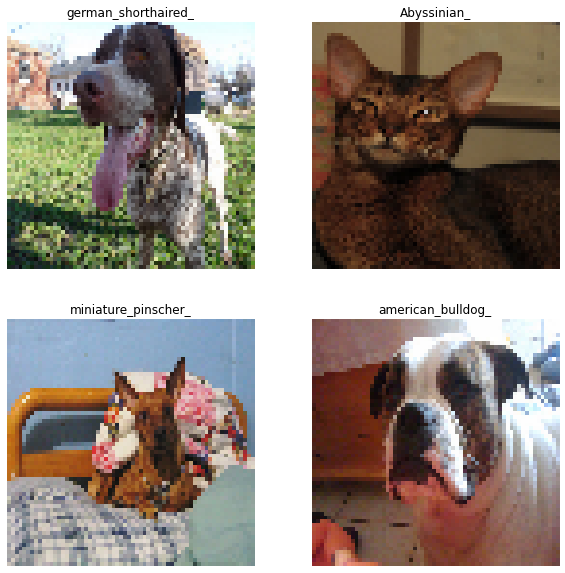

In [ ]:
from tensorflow import keras

reconstructed_model = keras.models.load_model("./Pet/saved_model")
with tf.device('/gpu:0'):
    predictions = reconstructed_model.predict(train_images)
    decoded_predictions_train = enc.inverse_transform(predictions)
view_test(decoded_predictions_train,train_images)

##  6.Mini project : CNN모델 개선하기

완성된 모델은 train set에서는 높은 성능을 보여주지만, 아직은 제가 가진 test set에서는 낮은 성능을 보여줄 겁니다.(여러분한테는 test set을 제공하지 않았습니다.) 

아래의 요소들을 고려해서 
- 모델의 레이어 구조
- 학습 파라미터
- data augmentation
- validation set 생성

test set에 대해서 일반화된 모델을 만들어보세요. 

또한 저희가 가진 test set에 대한 정확도에 따라서 순위를 매길겁니다! 모델의 변경한점과 결과를 레포트에 적어주세요.


In [ ]:
##todo !!!!


### 제출간 안내사항
완성된 모델은 아래의 코드를 돌려서 결과를 확인할 겁니다. 지금 상태에서 돌리더라도 train 데이터에 대해서, 확인이 가능할 겁니다. 저희가 평가할 때는 
함수의 첫 번째 인자를 **"imageData"**에서 **"test"**로 바꿔서 확인할겁니다.
코드 제출양식은 아래와 같이 구성된 Pet폴더를 압축해서 주세요. 


Pet
> L MiniProject#1.ipynb

> L saved_model

###※(주의) saved_model은 본인이 최종적으로 학습시킨 모델이어야합니다. 해당 모델은 저희가 평가할것입니다. 폴더 이름은 무조건 saved_model로 할것. (이거 안지키면 감점입니다)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from tensorflow import keras
from keras import models
import tensorflow as tf
from google.colab import drive
import os
import random

def test_accuracy(dataset, model_name):
  #구글드라이브 연결 
  drive.mount('/content/drive/')
  
  #이미 현재 경로가 설정되있다면
  if os.getcwd() != '/content/drive/My Drive':
    os.chdir('./drive/My Drive')
  print(os.getcwd())
  #원핫인코딩 설정
  origin_labels = np.array([0,1,2])
  
  if os.path.isfile("./train_label.npy"):#Pet폴더에 없는경우
    origin_labels = np.load("./train_label.npy")
  else : # Pet폴더에 있는경우
    origin_labels = np.load("./Pet/imageDataLabel_25.npy")
  enc= OneHotEncoder()
  origin_labels = origin_labels.reshape(-1,1)
  enc.fit(origin_labels)

  images = np.load("./Pet/"+dataset+"_25.npy")
  labels = np.load("./Pet/"+dataset+"Label_25.npy")

  #이미지 전처리
  images = images / 255.0

  #원핫 인코딩
  labels_new = labels.reshape(-1,1)
  labels_onehot = np.array(enc.transform(labels_new).toarray())
  # print(labels_onehot)
  #저장된 모델을 불러옴
  reconstructed_model = keras.models.load_model("./Pet/"+model_name)
  with tf.device('/gpu:0'):
      score = reconstructed_model.evaluate(images, labels_onehot, verbose=0)
      predictions = reconstructed_model.predict(images)
      decoded_predictions_train = enc.inverse_transform(predictions)

  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

#첫 번째 인자를 수정하세요.
test_accuracy(dataset="imageData",model_name="saved_model")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive
Test loss: 0.0009372533531859517
Test accuracy: 1.0
